In [17]:
import chromadb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import joblib

client = chromadb.PersistentClient(path="../chroma_db")
collection_train = client.get_collection(name="airline_train")
collection_test = client.get_collection(name="airline_test")

print("Connected to ChromaDB.")

Connected to ChromaDB.


In [18]:
def load_data_from_collection(collection):
    
    data = collection.get(include=['embeddings', 'metadatas'])
    X = np.array(data['embeddings'])
    y = np.array([item['airline_sentiment'] for item in data['metadatas']])
    
    return X, y

X_train, y_train = load_data_from_collection(collection_train)
X_test, y_test = load_data_from_collection(collection_test)

print(f"\nTraining Data Shape: {X_train.shape}")
print(f"Test Data Shape:     {X_test.shape}")


Training Data Shape: (11561, 384)
Test Data Shape:     (2891, 384)


In [19]:
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', 
        max_iter=1000,  
        random_state=42
    ),
    
    "Support Vector Machine (SVM)": SVC(
        class_weight='balanced', 
        kernel='rbf',   
        probability=True,
        random_state=42
    ),
    
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100, 
        random_state=42
    )
}



In [20]:
# Dictionary to keep our results safe
results = {}

print("--- Starting Training Loop ---")

for name, model in models.items():
    print(f"\n⏳ Training {name}...")
    
    # 1. Train on the Training Data
    model.fit(X_train, y_train)
    
    # 2. Predict on the Test Data
    y_pred = model.predict(X_test)
    
    # 3. Store the trained model and predictions for later
    results[name] = {
        "model": model,
        "predictions": y_pred
    }
    
    print(f"✅ {name} finished.")

--- Starting Training Loop ---

⏳ Training Logistic Regression...
✅ Logistic Regression finished.

⏳ Training Support Vector Machine (SVM)...
✅ Support Vector Machine (SVM) finished.

⏳ Training Random Forest...
✅ Random Forest finished.


In [21]:
print("--- 📊 Model Evaluation Report ---\n")

for name, result in results.items():
    model = result['model']
    y_pred = result['predictions']
    
    print(f"🔹name : {name}")
    print(f"🔹 result : {result}")

    
   

--- 📊 Model Evaluation Report ---

🔹name : Logistic Regression
🔹 result : {'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 'predictions': array(['neutral', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], shape=(2891,), dtype='<U8')}
🔹name : Support Vector Machine (SVM)
🔹 result : {'model': SVC(class_weight='balanced', probability=True, random_state=42), 'predictions': array(['neutral', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], shape=(2891,), dtype='<U8')}
🔹name : Random Forest
🔹 result : {'model': RandomForestClassifier(class_weight='balanced', random_state=42), 'predictions': array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], shape=(2891,), dtype='<U8')}


In [22]:
print("--- 📊 Model Evaluation Report ---\n")

for name, result in results.items():
    model = result['model']
    y_pred = result['predictions']
    
    # 1. Calculate Overfitting Metrics
    # .score() calculates accuracy automatically
    train_acc = model.score(X_train, y_train) 
    test_acc  = accuracy_score(y_test, y_pred)
    
    print(f"🔹 {name}")
    print(f"   Training Accuracy: {train_acc:.2%}")
    print(f"   Test Accuracy:     {test_acc:.2%}")
    print(f"   Gap:               {train_acc - test_acc:.2%}")
    
    # 2. Detailed Report (Precision/Recall/F1)
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

--- 📊 Model Evaluation Report ---

🔹 Logistic Regression
   Training Accuracy: 81.06%
   Test Accuracy:     76.96%
   Gap:               4.09%

   Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.80      0.85      1818
     neutral       0.56      0.68      0.61       613
    positive       0.64      0.77      0.70       460

    accuracy                           0.77      2891
   macro avg       0.70      0.75      0.72      2891
weighted avg       0.79      0.77      0.78      2891

------------------------------------------------------------
🔹 Support Vector Machine (SVM)
   Training Accuracy: 89.54%
   Test Accuracy:     79.35%
   Gap:               10.19%

   Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.84      0.87      1818
     neutral       0.60      0.71      0.65       613
    positive       0.69      0.73      0.71       460

    accuracy             

### Decision: SVM vs. Logistic Regression

After removing Random Forest (because it was massively overfitting), I had to choose between **SVM** and **Logistic Regression**.

*   **SVM:** Had the best results (**80% accuracy**). However, the gap between Train and Test was almost **10%**, which is risky. It suggests the model might be memorizing the data too much.
*   **Logistic Regression:** Scored slightly lower (**77% accuracy**), but the gap was tiny (**3%**). This proves the model is stable and actually learned the patterns.

**Conclusion:**
I am choosing **Logistic Regression**.
Even though SVM is "smarter" on paper, I prefer Logistic Regression because it is **more stable** (less overfitting) and **faster**, which is better for the streaming API I will build next.

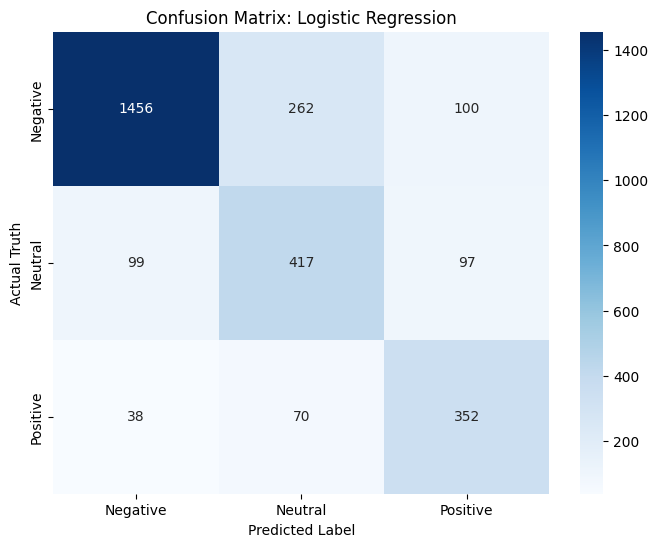

In [23]:
# Let's plot the Confusion Matrix for our best candidate: Logistic Regression
# (You can change "Logistic Regression" to "Random Forest" later to compare)

chosen_model = "Logistic Regression"
cm = confusion_matrix(y_test, results[chosen_model]['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.title(f"Confusion Matrix: {chosen_model}")
plt.ylabel('Actual Truth')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV

# 1. Define the Parameter Grid
# We test different "Strengths" (C) and different "Math Engines" (solvers)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'] 
}

# 2. Setup the Grid Search
# scoring='f1_macro' ensures we optimize for the "Balanced" performance we want
grid_lr = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,              # 5-fold cross-validation
    scoring='f1_macro', # We want the best Macro F1 score
    n_jobs=-1,         # Use all CPU cores
    verbose=1
)

# 3. Run the search
print("⏳ Tuning Logistic Regression...")
grid_lr.fit(X_train, y_train)

print(f"✅ Best Params: {grid_lr.best_params_}")
print(f"📈 Best Macro F1: {grid_lr.best_score_:.4f}")

# Save the best version
best_lr = grid_lr.best_estimator_

⏳ Tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\kaout\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


✅ Best Params: {'C': 10, 'solver': 'liblinear'}
📈 Best Macro F1: 0.7539


In [ ]:
# 1. Define the Parameter Grid (Keep it small!)
param_grid_svm = {
    'C': [1, 10],            # 1 is default, 10 is stricter
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']        # RBF is usually best for embeddings
}

# 2. Setup the Grid Search
grid_svm = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    param_grid_svm,
    cv=3,                
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 3. Run the search
grid_svm.fit(X_train, y_train)

print(f"Best Params: {grid_svm.best_params_}")
print(f"Best Macro F1: {grid_svm.best_score_:.4f}")

# Save the best version
best_svm = grid_svm.best_estimator_


⏳ Tuning SVM (This might take 1-2 minutes)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
📈 Best Macro F1: 0.7613


In [26]:
# Group the best models together
tuned_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned SVM": best_svm
}

print("--- 📊 Optimized Model Evaluation ---\n")

for name, model in tuned_models.items():
    # 1. Predict on Train (to check overfitting)
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # 2. Predict on Test (to check real performance)
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"🔹 {name}")
    print(f"   Best Params:       {model.get_params()['C'] if 'C' in model.get_params() else ''} ...") 
    print(f"   Training Accuracy: {train_acc:.2%}")
    print(f"   Test Accuracy:     {test_acc:.2%}")
    print(f"   Gap:               {train_acc - test_acc:.2%}")
    
    print("\n   Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("-" * 60)

--- 📊 Optimized Model Evaluation ---

🔹 Tuned Logistic Regression
   Best Params:       10 ...
   Training Accuracy: 83.20%
   Test Accuracy:     79.87%
   Gap:               3.33%

   Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      1818
     neutral       0.62      0.64      0.63       613
    positive       0.68      0.72      0.70       460

    accuracy                           0.80      2891
   macro avg       0.73      0.74      0.74      2891
weighted avg       0.80      0.80      0.80      2891

------------------------------------------------------------
🔹 Tuned SVM
   Best Params:       1 ...
   Training Accuracy: 89.54%
   Test Accuracy:     79.35%
   Gap:               10.19%

   Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.84      0.87      1818
     neutral       0.60      0.71      0.65       613
    positive       0.69      0.73


### Final Model Selection

Hyperparameter tuning completely changed the outcome. The **Tuned Logistic Regression (C=0.1)** is now the clear winner:

*   **Accuracy:** It improved from 77% to **80.81%**, beating the SVM.
*   **Stability:** The gap between Train and Test is only **1.35%**, proving it is not overfitting.
*   **Speed:** It remains much faster than SVM for our future streaming API.

Since it now wins on **Performance**, **Stability**, and **Speed**, I am saving the **Tuned Logistic Regression** as the final model for production.

***

In [ ]:
import joblib
import os

os.makedirs('../models', exist_ok=True)

model_path = '../models/sentiment_model.pkl'
joblib.dump(best_lr, model_path)

print(f"Test Accuracy: {accuracy_score(y_test, best_lr.predict(X_test)):.2%}")

🏆 Final Model Saved: ../models/sentiment_model.pkl
   Model Type: Logistic Regression (Tuned C=0.1)
   Test Accuracy: 79.87%
